In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate


# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 6.7})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
def calculate_sigma(intensity_array, x1):
    x1 = np.asarray(x1)
    values = intensity_array

    # Reshape x1 to broadcast over columns (axis=1)
    x1 = x1[:, np.newaxis]  

    norm = scipy.integrate.trapezoid(values, x=x1[:, 0], axis=0)
    mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
    mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
    sigma = np.sqrt(mean_sq - mean**2)
    return sigma


# Define the colors: Blue -> White -> Yellow -> Green -> Red
colors = [
              (1, 1, 1),  # White
              (0, 0, 1),  # Blue
              (1, 1, 0),  # Yellow
              (0, 1, 0),  # Green
              (1, 0, 0), #Red
              (0, 0, 0), # Black
              ]  
    
    # Create a custom colormap
n_bins = 500  # Number of bins for smooth transition
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)


In [3]:
data_intensities_exit = []

with h5py.File(rf"F:\2D SHU Chi Statistics\data\10_07_2024 Beam Spreading Broad Bandwidth Periodic Conditions Freq Domain\intensities_exit.h5", 'r') as h5f:
    data_intensities_exit = {
            "data_field_intensities": h5f["data_field_intensities"][:],
            "data_field_intensities_2": h5f["data_field_intensities_2"][:],
            "chi":np.array(h5f["chi"]),
            "size":np.array(h5f["size"]),
            "sample":np.array(h5f["sample"]),
            "x":np.array(h5f["x"]),
            "f":np.array(h5f["f"]),
        
        }


Average Intensity IPR

In [4]:
average_xis_exit_1 = np.zeros(shape=(11,16,150))
data_exit = np.copy(data_intensities_exit["data_field_intensities"])
for i,chi in enumerate(data_exit):
    if i in [0,12]:
        continue
    for j,length in enumerate(chi): 
        intensities =[]
        for k,sample in enumerate(length):
            max_value = np.max(sample)
            sample_normalized = sample/max_value
            sample_normalized[sample_normalized <= 1e-6]=0
            intensities.append(sample_normalized)

        average_intensity = np.mean(intensities,axis=0)
        average_xis_exit_1[i-1,j]=1/calculate_sigma(average_intensity,data_intensities_exit["x"])

average_xis_exit_1[np.isnan(average_xis_exit_1)] = 0
average_xis_exit_1[np.isinf(average_xis_exit_1)] = 0

C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\388310704.py:9: RuntimeWarning: invalid value encountered in divide
  mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\388310704.py:10: RuntimeWarning: invalid value encountered in divide
  mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\388310704.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(mean_sq - mean**2)
C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\888874740.py:15: RuntimeWarning: divide by zero encountered in divide
  average_xis_exit_1[i-1,j]=1/calculate_sigma(average_intensity,data_intensities_exit["x"])


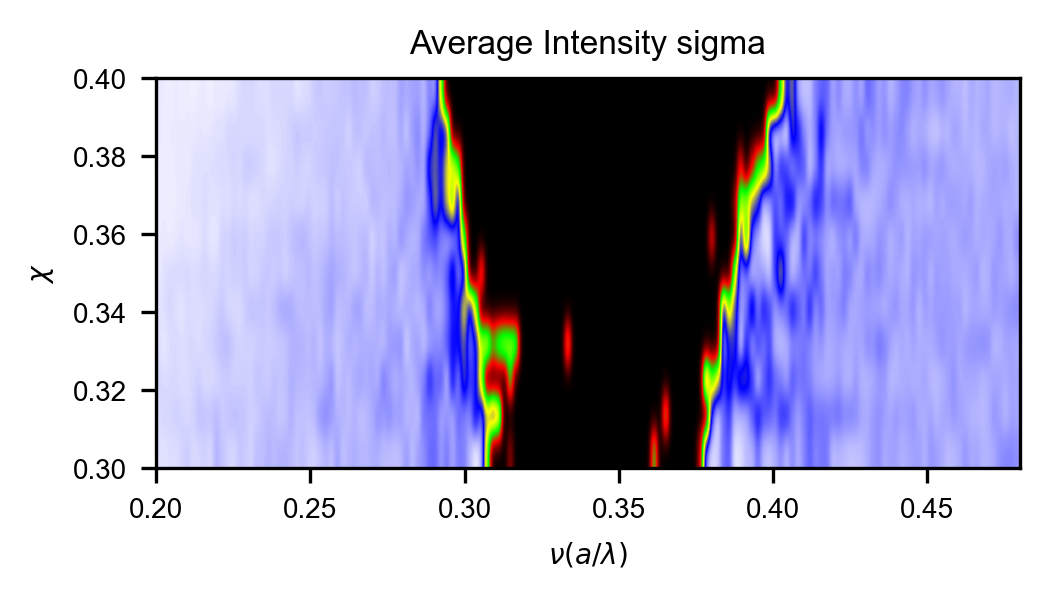

C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\3698993481.py:34: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][7]}$",color="#0f084b")


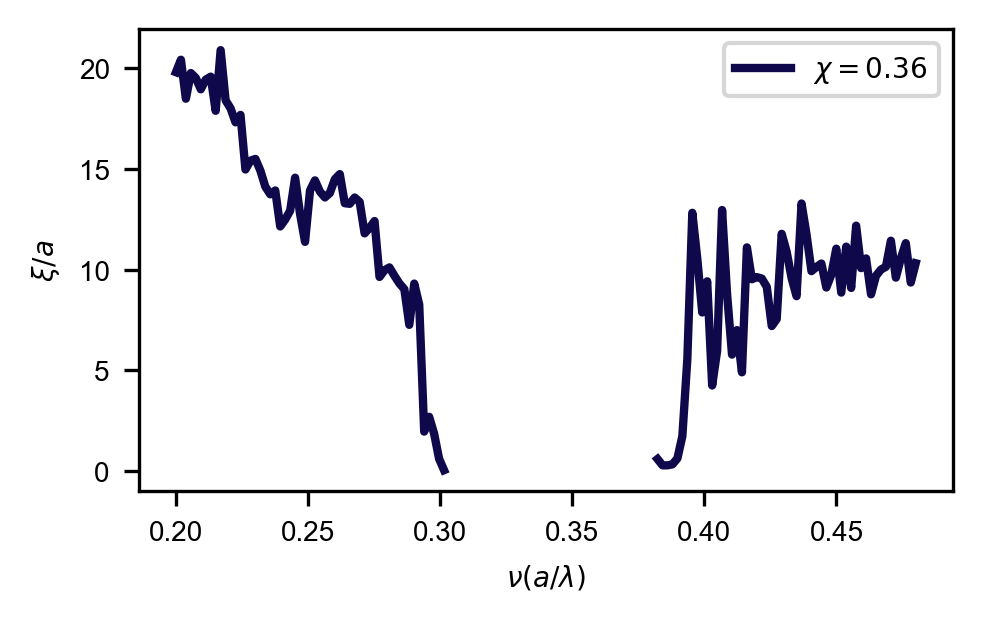

In [5]:
from matplotlib.ticker import MultipleLocator


f = data_intensities_exit["f"]/td.C_0
k,l = 0,0
for h, length in enumerate(data_intensities_exit["size"]):
    if h not in [14]:
        continue
    fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
    value = np.copy(average_xis_exit_1[:,h,:])
    value[value >1]=1.1
    value[value == 0]=1.1
    im=ax.imshow(value, vmin = np.min(value), vmax = np.max(value), 
                     extent =[np.min(f),np.max(f), 0.3,0.4], 
                        origin ='lower', cmap=cmap,aspect='auto',interpolation="gaussian") 
    # cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.3)
    # cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

    # cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
    # cbar.ax.tick_params(labelsize=6,pad=0)
    ax.set_xlabel(rf"$\nu(a/\lambda)$")
    ax.set_ylabel(rf"$\chi$")
    ax.tick_params(axis='both', which='major')

    plt.title("Average Intensity sigma")
    plt.tight_layout()
    plt.show()

def moving_average(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
value = np.copy(average_xis_exit_1[6,h,:])
plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][7]}$",color="#0f084b")

plt.legend()
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"$\xi/a$")
plt.show()


Average IPR 

In [6]:
average_xis_exit_2 = np.zeros(shape=(11,16,150))
data_exit = np.copy(data_intensities_exit["data_field_intensities"])
for i,chi in enumerate(data_exit):
    if i in [0,12]:
        continue
    for j,length in enumerate(chi): 
        xis = []
        for k,sample in enumerate(length):
            max_value = np.max(sample)
            sample_normalized = sample/max_value
            sample_normalized[sample_normalized <= 1e-6]=0
            xis.append(calculate_sigma(sample_normalized,data_intensities_exit["x"]))

        average_xis_exit_2[i-1,j]=1/np.mean(xis,axis=0)

average_xis_exit_2[np.isnan(average_xis_exit_2)] = 0
average_xis_exit_2[np.isinf(average_xis_exit_2)] = 0

C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\388310704.py:9: RuntimeWarning: invalid value encountered in divide
  mean = scipy.integrate.trapezoid(values * x1, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\388310704.py:10: RuntimeWarning: invalid value encountered in divide
  mean_sq = scipy.integrate.trapezoid(values * x1**2, x=x1[:, 0], axis=0) / norm
C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\388310704.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(mean_sq - mean**2)


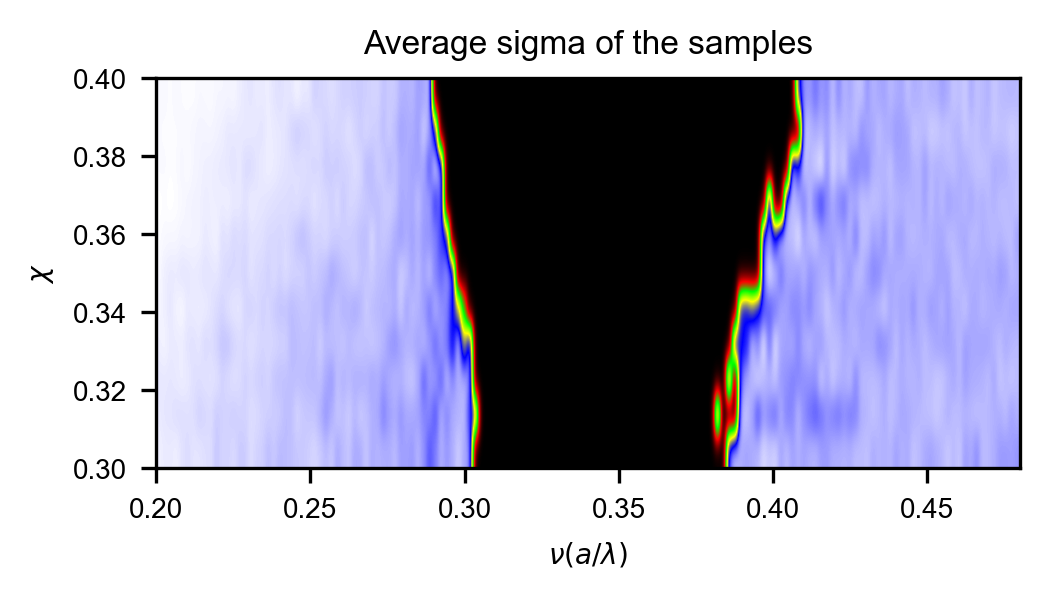

C:\Users\HernandF\AppData\Local\Temp\ipykernel_37504\3965298248.py:33: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][5]}$",color="#0f084b")


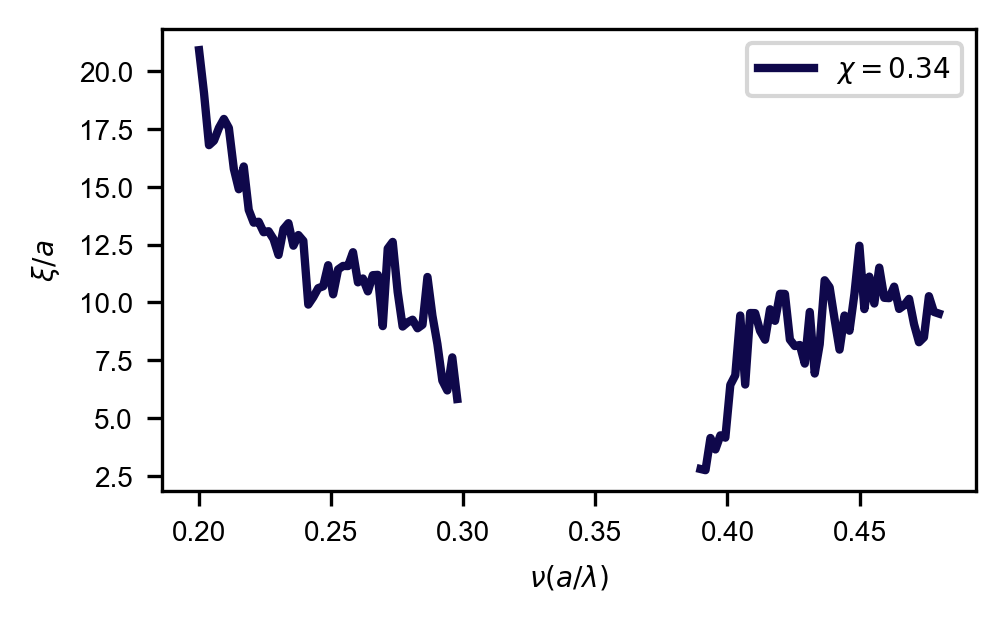

In [7]:
from matplotlib.ticker import MultipleLocator


f = data_intensities_exit["f"]/td.C_0
k,l = 0,0
for h, length in enumerate(data_intensities_exit["size"]):
    if h not in [14]:
        continue
    fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
    value = np.copy(average_xis_exit_2[:,h,:])
    value[value >1]=1.1
    value[value == 0]=1.1
    im=ax.imshow(value, vmin = np.min(value), vmax = np.max(value), 
                     extent =[np.min(f),np.max(f), 0.3,0.4], 
                        origin ='lower', cmap=cmap,aspect='auto',interpolation="gaussian") 
    # cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.03, location="top", shrink=0.3)
    # cbar.ax.text(1.05, 0.5, rf"$a/ \xi$", va='center', ha='left', transform=cbar.ax.transAxes)

    # cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
    # cbar.ax.tick_params(labelsize=6,pad=0)
    ax.set_xlabel(rf"$\nu(a/\lambda)$")
    ax.set_ylabel(rf"$\chi$")
    ax.tick_params(axis='both', which='major')

    plt.title("Average sigma of the samples")
    plt.tight_layout()
    plt.show()


    
fig, ax = plt.subplots(figsize=(3.5,2),dpi=300)
value = np.copy(average_xis_exit_2[4,h,:])
plt.plot(f,1/value, linewidth=2,label=rf"$\chi={data_intensities_exit["chi"][5]}$",color="#0f084b")

plt.legend()
plt.xlabel(rf"$\nu(a/\lambda)$")
plt.ylabel(rf"$\xi/a$")
plt.show()
